# To visualize small cutouts in Rubin and Euclid together

#### helpers and imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.geom as geom

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astroquery.ipac.irsa import Irsa
import fsspec


def robust_imshow(ax, img, title="", p=(1, 99)):
    if img is None:
        ax.set_title(f"{title} (missing)")
        ax.axis("off")
        return
    lo, hi = np.nanpercentile(img, p)
    ax.imshow(img, origin="lower", vmin=lo, vmax=hi)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])

def save_bundle(path, **kw):
    np.savez_compressed(path, **{k: v for k, v in kw.items() if v is not None})
    print("saved:", path)

def load_rubin_cutouts(ra, dec, size_arcsec, bands, repo="dp1", collection="LSSTComCam/DP1"):
    butler = Butler(repo, collections=collection) 
    pixscale = 0.2  # arcsec/pix for LSST coadd-like images (good enough for a visual check)
    n = int(np.round(size_arcsec / pixscale))
    if n % 2 == 1:
        n += 1

    out = {}
    for b in bands:
        refs = butler.query_datasets(
            "deep_coadd",
            where="band.name = band AND patch.region OVERLAPS POINT(ra, dec)",
            bind={"band": b, "ra": ra, "dec": dec},
            with_dimension_records=True,
            order_by=["patch.tract"],
        )  # pattern used in the ECDFS notebook :contentReference[oaicite:2]{index=2}

        refs = list(refs)
        if not refs:
            out[b] = None
            continue

        dataId = refs[0].dataId
        wcs = butler.get("deep_coadd.wcs", dataId=dataId)  # :contentReference[oaicite:3]{index=3}
        sp = geom.SpherePoint(ra, dec, geom.degrees)
        xy = geom.PointI(wcs.skyToPixel(sp))

        bbox = geom.BoxI(xy - geom.ExtentI(n, n)//2, geom.ExtentI(n, n))
        cut = butler.get("deep_coadd", dataId=dataId, parameters={"bbox": bbox})  # :contentReference[oaicite:4]{index=4}

        out[b] = cut.image.array  # 2D numpy
    return out


def load_euclid_cutouts(ra, dec, size_arcsec, bands=("VIS","Y","J","H"),
                       collection="euclid_DpdMerBksMosaic", radius_arcsec=10):
    import numpy as np
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    from astropy.io import fits
    from astropy.nddata import Cutout2D
    from astropy.wcs import WCS
    from astroquery.ipac.irsa import Irsa
    import fsspec

    coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame="icrs")
    res = Irsa.query_sia(pos=(coord, radius_arcsec*u.arcsec), collection=collection)

    tab = res.to_table()  # <-- key fix (DALResults -> Table)

    if "dataproduct_subtype" in tab.colnames:
        tab = tab[tab["dataproduct_subtype"] == "science"]

    out = {b: None for b in bands}
    for b in bands:
        if "energy_bandpassname" in tab.colnames:
            rows = tab[tab["energy_bandpassname"] == b]
        else:
            rows = tab  # fallback
        if len(rows) == 0:
            continue

        url = rows["access_url"][0]

        with fsspec.open(url, "rb") as f:
            with fits.open(f, memmap=False) as hdul:
                wcs = WCS(hdul[0].header)
                cut = Cutout2D(hdul[0].data, coord, size_arcsec*u.arcsec, wcs=wcs)
                out[b] = np.array(cut.data, dtype=np.float32)

    return out




### Target

In [5]:
ra, dec = 53.16, -28.10 #this is center of ECDFS (Rubin spans ~1degree diameter)
size_arcsec = 30.0
bands_rubin = ["u","g","r","i","z","y"]
bands_euclid = ["VIS","Y","J","H"]


### Plot

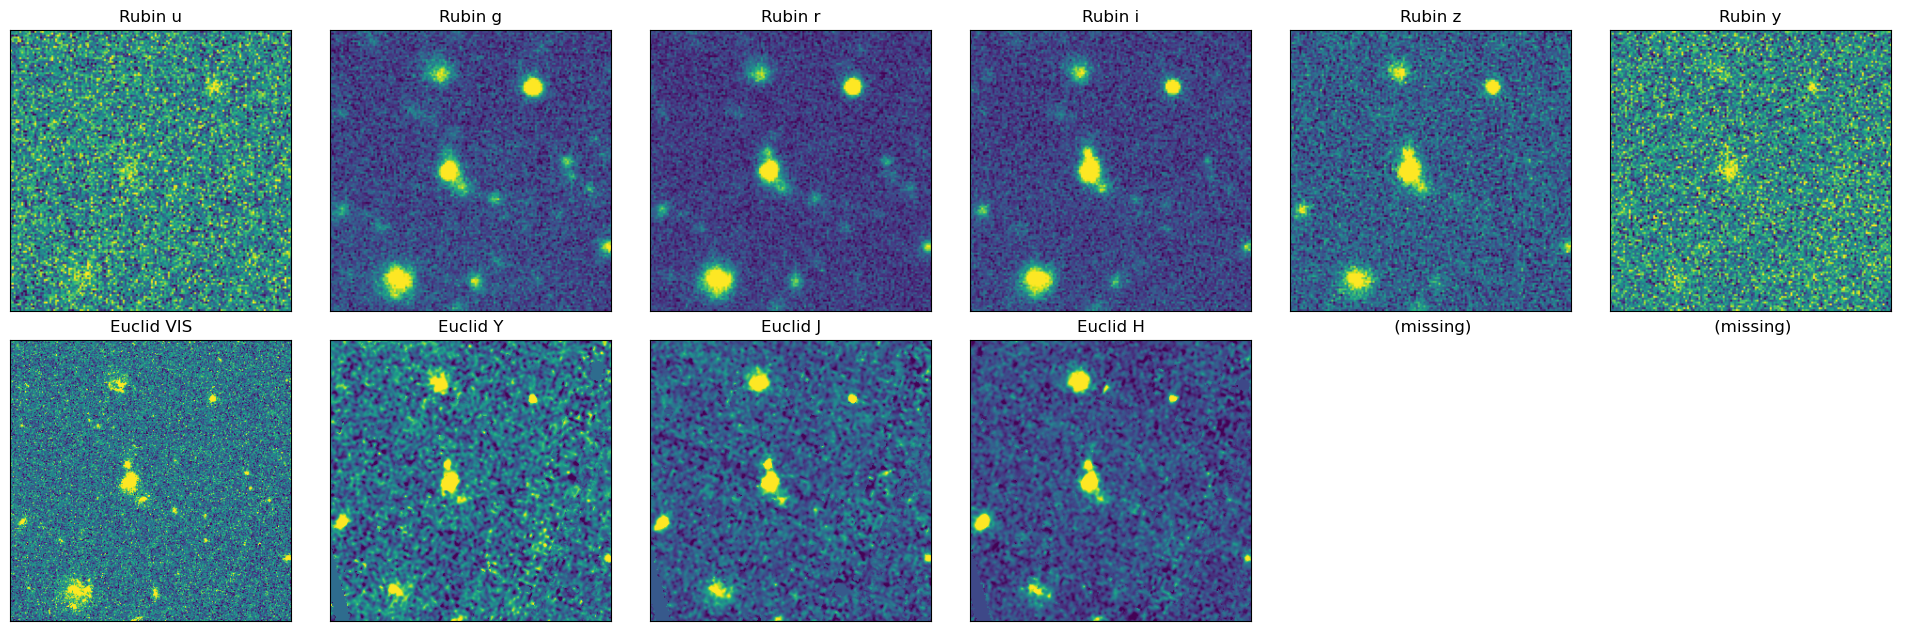

In [6]:
rub = load_rubin_cutouts(ra, dec, size_arcsec, bands_rubin)
euc = load_euclid_cutouts(ra, dec, size_arcsec, bands_euclid)

ncol = max(len(bands_rubin), len(bands_euclid))
fig, axes = plt.subplots(2, ncol, figsize=(3.2*ncol, 6.2), constrained_layout=True)

for j in range(ncol):
    ax = axes[0, j]
    b = bands_rubin[j] if j < len(bands_rubin) else ""
    robust_imshow(ax, rub.get(b), f"Rubin {b}" if b else "")

for j in range(ncol):
    ax = axes[1, j]
    b = bands_euclid[j] if j < len(bands_euclid) else ""
    robust_imshow(ax, euc.get(b), f"Euclid {b}" if b else "")

plt.show()


In [ ]:
out = f"../data/joint/ecdfs_ra{ra:.5f}_dec{dec:.5f}_s{size_arcsec:.0f}as.npz"
save_bundle(out,
            ra=np.array([ra]), dec=np.array([dec]), size_arcsec=np.array([size_arcsec]),
            **{f"rub_{b}": rub.get(b) for b in bands_rubin},
            **{f"euc_{b}": euc.get(b) for b in bands_euclid})
